In [86]:
import numpy as np
import pandas as pd
import re

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go


%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor  
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV

from IPython.display import display, HTML, Javascript
display(HTML("<style>.output_scroll { height: auto; max-height: 48ex; }</style>"))

display(Javascript(
    """
    IPython.OutputArea.prototype._should_scroll = function(lines) {
        return false;
    }
    """
))

<IPython.core.display.Javascript object>

## Часть 1. Знакомство с данными

In [2]:
# Загрузим наш датафрейм
hotels = pd.read_csv('hotels.csv')

In [3]:
# Посмотрим его содержимое
print(hotels.shape)
hotels.info()

(386803, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-nu

In [4]:
hotels.columns

Index(['hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [5]:
# Найдем пропуски в каждом столбце нашего датафрейма
missing_values = hotels.isnull().sum()
missing_values

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

Пропуски содержатся в признаках **lat** и **lng**. Это указывает на отсутствие географических координат для некоторых отелей. С заполнением этих пропусков нам предстоит поработать.

In [6]:
# Найдем кол-во уникальных названий отелей
unique_hotel_names = hotels['hotel_name'].nunique()
print(f"Количество уникальных названий отелей: {unique_hotel_names}")

Количество уникальных названий отелей: 1492


In [7]:
# Найдем дату самого свежего отзыва 
# Ответ выведем в формате yyyy-mm-dd
# Преобразуем столбец review_date в нужный формат даты
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

# Найдем самый свежий отзыв
most_recent_review = hotels['review_date'].max()
print(f"Дата самого свежего отзыва: {most_recent_review.strftime('%Y-%m-%d')}")

# Найдем самый ранний отзыв
earliest_review = hotels['review_date'].min()
print(f"Дата самого раннего отзыва: {earliest_review.strftime('%Y-%m-%d')}")

Дата самого свежего отзыва: 2017-08-03
Дата самого раннего отзыва: 2015-08-04


In [8]:
# Найдем кол-во уникальных тегов
# Для этого нам нужно преобразовать строки с тегами в список уникальных тегов
unique_tags = set()
hotels['tags'].str.split(',').apply(unique_tags.update)

# Подсчитаем кол-ва уникальных тегов
num_unique_tags = len(unique_tags)
print(f"Количество уникальных тегов: {num_unique_tags}")

Количество уникальных тегов: 2413


In [9]:
# Попробуем найти тег который участвует в наибольшем числе отзывов 
# Для этого:

# 1) Преобразуем каждую строку тегов в список отдельных тегов 
all_tags = []
for tags in hotels['tags']:
    # Разделяем теги и добавляем в список
    all_tags.extend(tags.split(','))

# 2) Подсчитаем вхождения каждого тега
tag_counts = Counter(all_tags)

# 3) Найдем наиболее часто встречающийся тег
most_common_tag = tag_counts.most_common(1)[0]
print(f"Наиболее часто встречающийся тег: {most_common_tag[0]} с числом вхождений: {most_common_tag[1]}")


Наиболее часто встречающийся тег: [' Leisure trip ' с числом вхождений: 312768


In [10]:
# Попробуем выяснить из тегов, на сколько ночей чаще всего останавливаются путешественники в отелях

# Для этого необходимо выполнить слежующие шаги:
# 1) Найти и отфильтровать теги, которые явно указывают на количество ночей пребывания;
# 2) Извлечь числовые значения, представляющие количество ночей, из этих тегов;
# 3) Подсчитать, сколько раз каждое количество ночей упоминается в тегах;
# 4) Найти, какое количество ночей встречается чаще всего.

# Функция для извлечения количества ночей из тега
def extract_nights(tag):
    match = re.search(r'Stayed (\d+) night(s)?', tag)
    return int(match.group(1)) if match else None

# Извлечем информацию о кол-ве ночей из каждого тега
nights = []
for tags_str in hotels['tags']:
    tags = tags_str.split(',')
    for tag in tags:
        nights_count = extract_nights(tag)
        if nights_count:
            nights.append(nights_count)

# Подсчитаем кол-во каждой длительности пребывания
nights_counts = Counter(nights)

# Определим наиболее частую длительность пребывания путешественников в отелях
most_common_nights = nights_counts.most_common(1)[0]
print(f"Наиболее частая длительность пребывания: {most_common_nights[0]} ночей, встречается {most_common_nights[1]} раз")

Наиболее частая длительность пребывания: 1 ночей, встречается 145373 раз


## Часть 2. Подготовка данных, заполнение пропусков, первое обучение модели

Теперь нам надо подготовить наши данные перед созданием ML-модели. Целевой переменной у нас будет **reviewer_score**

In [11]:
# Оставим оригинальный датафрейм используя далее его копию
hotels_df = hotels.copy()

In [12]:
# Убираем признаки "object" из датафрейма так как наша модель не сможет обучаться на них и выдаст ошибку 
# Поэтому просто отберем их и удалим
object_columns = [s for s in hotels_df.columns if hotels_df[s].dtypes == 'object']
hotels_df.drop(object_columns, axis = 1, inplace=True)

In [13]:
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 10 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                386803 non-null  int64         
 1   review_date                                 386803 non-null  datetime64[ns]
 2   average_score                               386803 non-null  float64       
 3   review_total_negative_word_counts           386803 non-null  int64         
 4   total_number_of_reviews                     386803 non-null  int64         
 5   review_total_positive_word_counts           386803 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  386803 non-null  int64         
 7   reviewer_score                              386803 non-null  float64       
 8   lat                                         384355 non-null  float64      

Пропуски у признаков **lat** и **lng** нужно будет заполнить, так как эти признаки числовые и они нам будут нужны для обучения ML-модели.

Для заполнения пропусков я хочу использовать метод K-Nearest Neighbors (KNN). Основная идея алгоритма KNN заключается в том, чтобы классифицировать объекты на основе ближайших к ним образцов в обучающем наборе данных. Но мы возьмем его инструмент KNNImputer для заполнения отсутствующих значений в данных. Он применяет алгоритм k-ближайших соседей (k-NN) для импутации, то есть находит k-ближайших соседей для записи с отсутствующим значением и заполняет пропуски средним значений этих соседей.

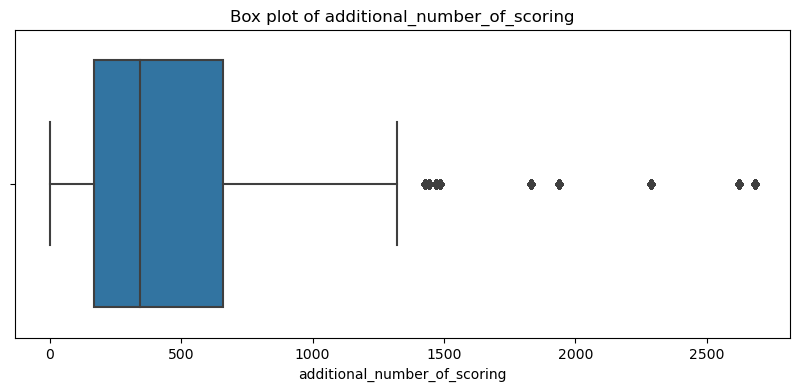

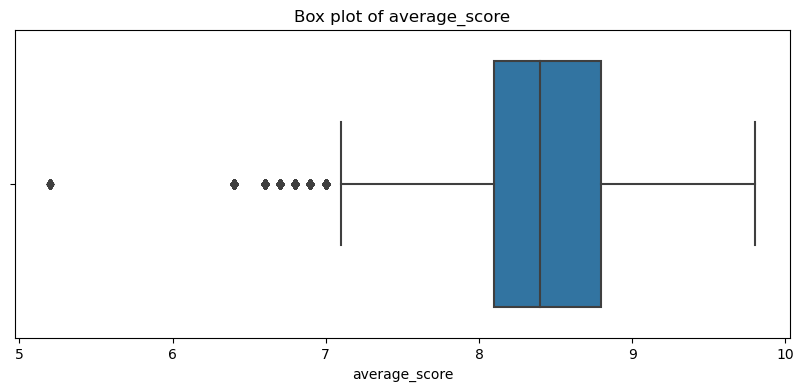

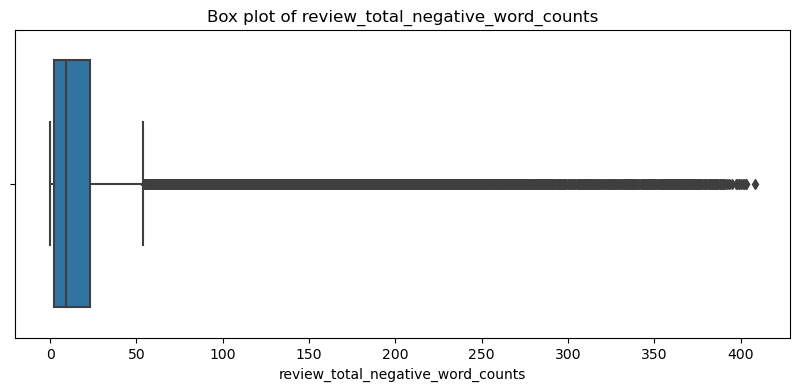

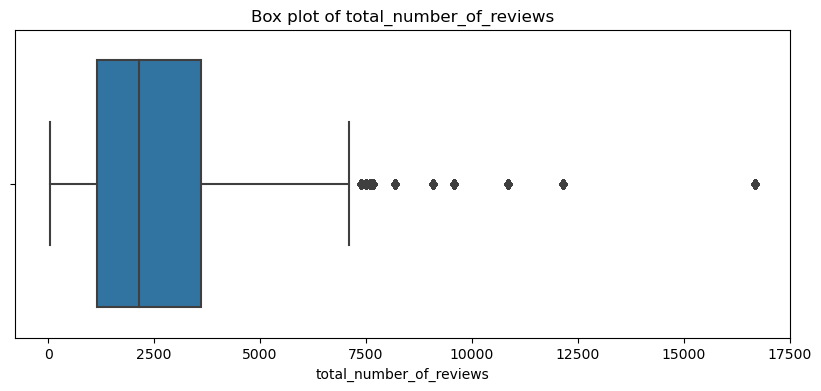

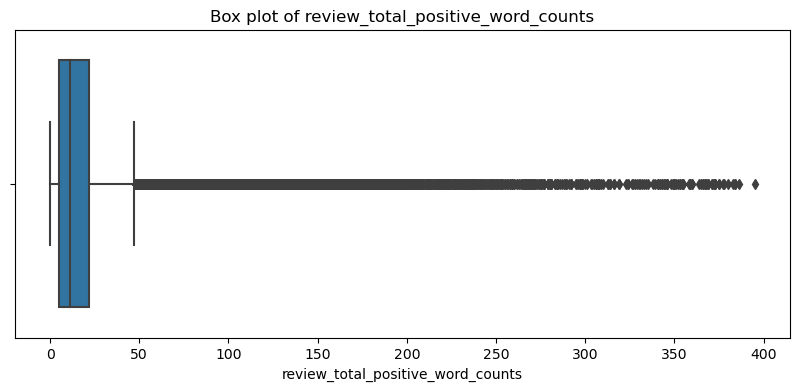

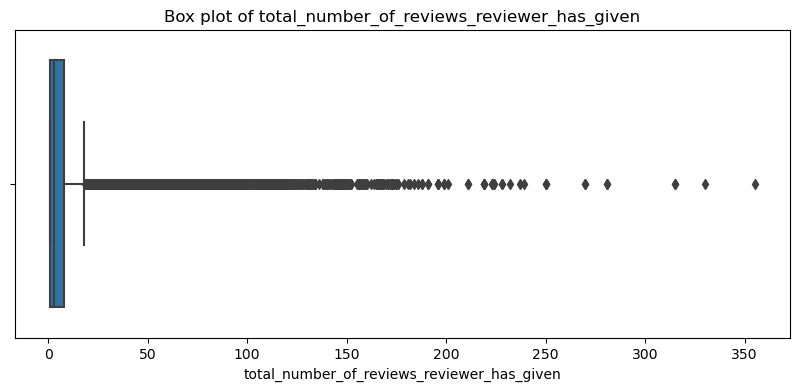

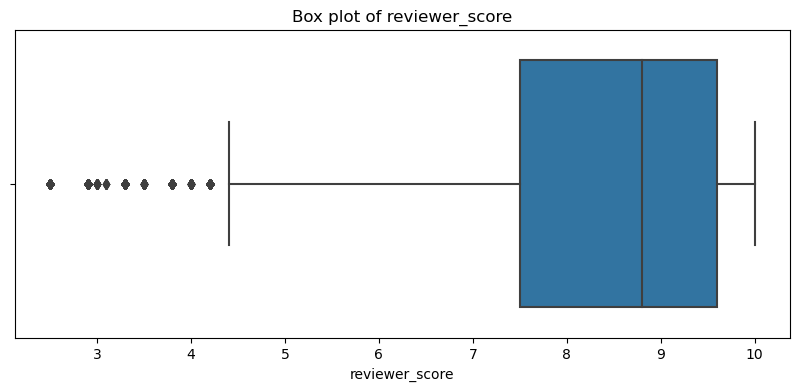

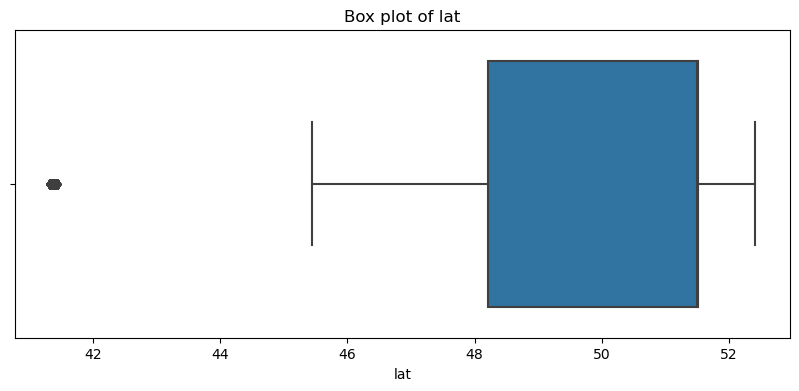

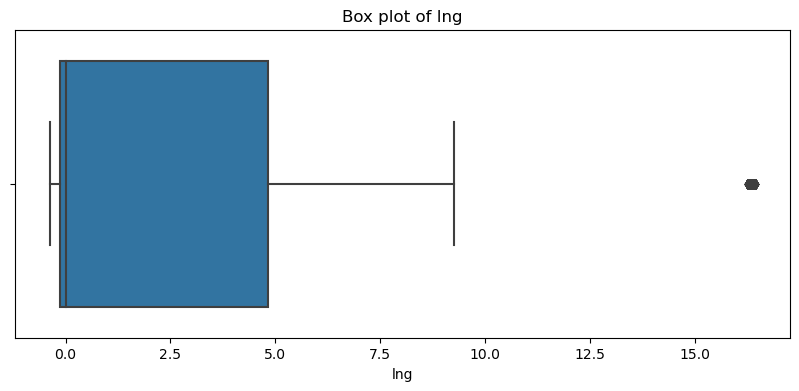

In [14]:
# Посмотрим на наши выбросы
# Выбор только числовых столбцов за исключением столбца с датами
numerical_columns = hotels_df.select_dtypes(include=[np.number])

# Создадим ящики с усами для каждого числового признака
for column in numerical_columns.columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=numerical_columns[column])
    plt.title(f"Box plot of {column}")
    plt.show()


Как мы видим выбросы присутствуют во всех числовых признаках нашего датафрейма. Но с учетом того, что мы применим нормализацию и будем обучать модель случайного леса который считается относительно устойчивым к выбросам. На данном этапе мы не будем работать с выбросами другими способами.

#### Коррелярность для выявления признаков 

Для применения KNN нам нужно определить признаки которые больше всего коррелируют с **lat** и **lng**.

In [15]:
# Расчет корреляции Пирсона
correlation_matrix = hotels_df.corr(numeric_only=True)

# Отображение корреляции с lat и lng
correlation_with_lat_lng = correlation_matrix.loc[['lat', 'lng'], :]
correlation_with_lat_lng


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
lat,0.336362,-0.107855,0.019346,0.100163,-0.038613,-0.059497,-0.036984,1.000000,-0.304338
lng,-0.296060,0.106222,-0.020870,-0.014247,0.035285,0.109414,0.034829,-0.304338,1.000000


Корреляция по Пирсону указала на **additional_number_of_scoring** как лучший признак который коррелирует с нашими признаками. 

In [16]:
# Расчет корреляции Спирмена
correlation_matrix_spearman = hotels_df.corr(numeric_only=True, method='spearman')

# Отображение корреляции с lat и lng
correlation_with_lat_lng_spearman = correlation_matrix_spearman.loc[['lat', 'lng'], :]
correlation_with_lat_lng_spearman


,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng
lat,0.425741,-0.085161,0.037113,0.151415,-0.026457,-0.10023,-0.028372,1.000000,-0.323601
lng,-0.384824,0.180013,-0.049904,-0.043954,0.060251,0.11718,0.063785,-0.323601,1.000000


Корреляция по Спирмену также выявила **additional_number_of_scoring**

Давайте взглянем на все признаки через две тепловые карты по Пирсону и Спирмену.

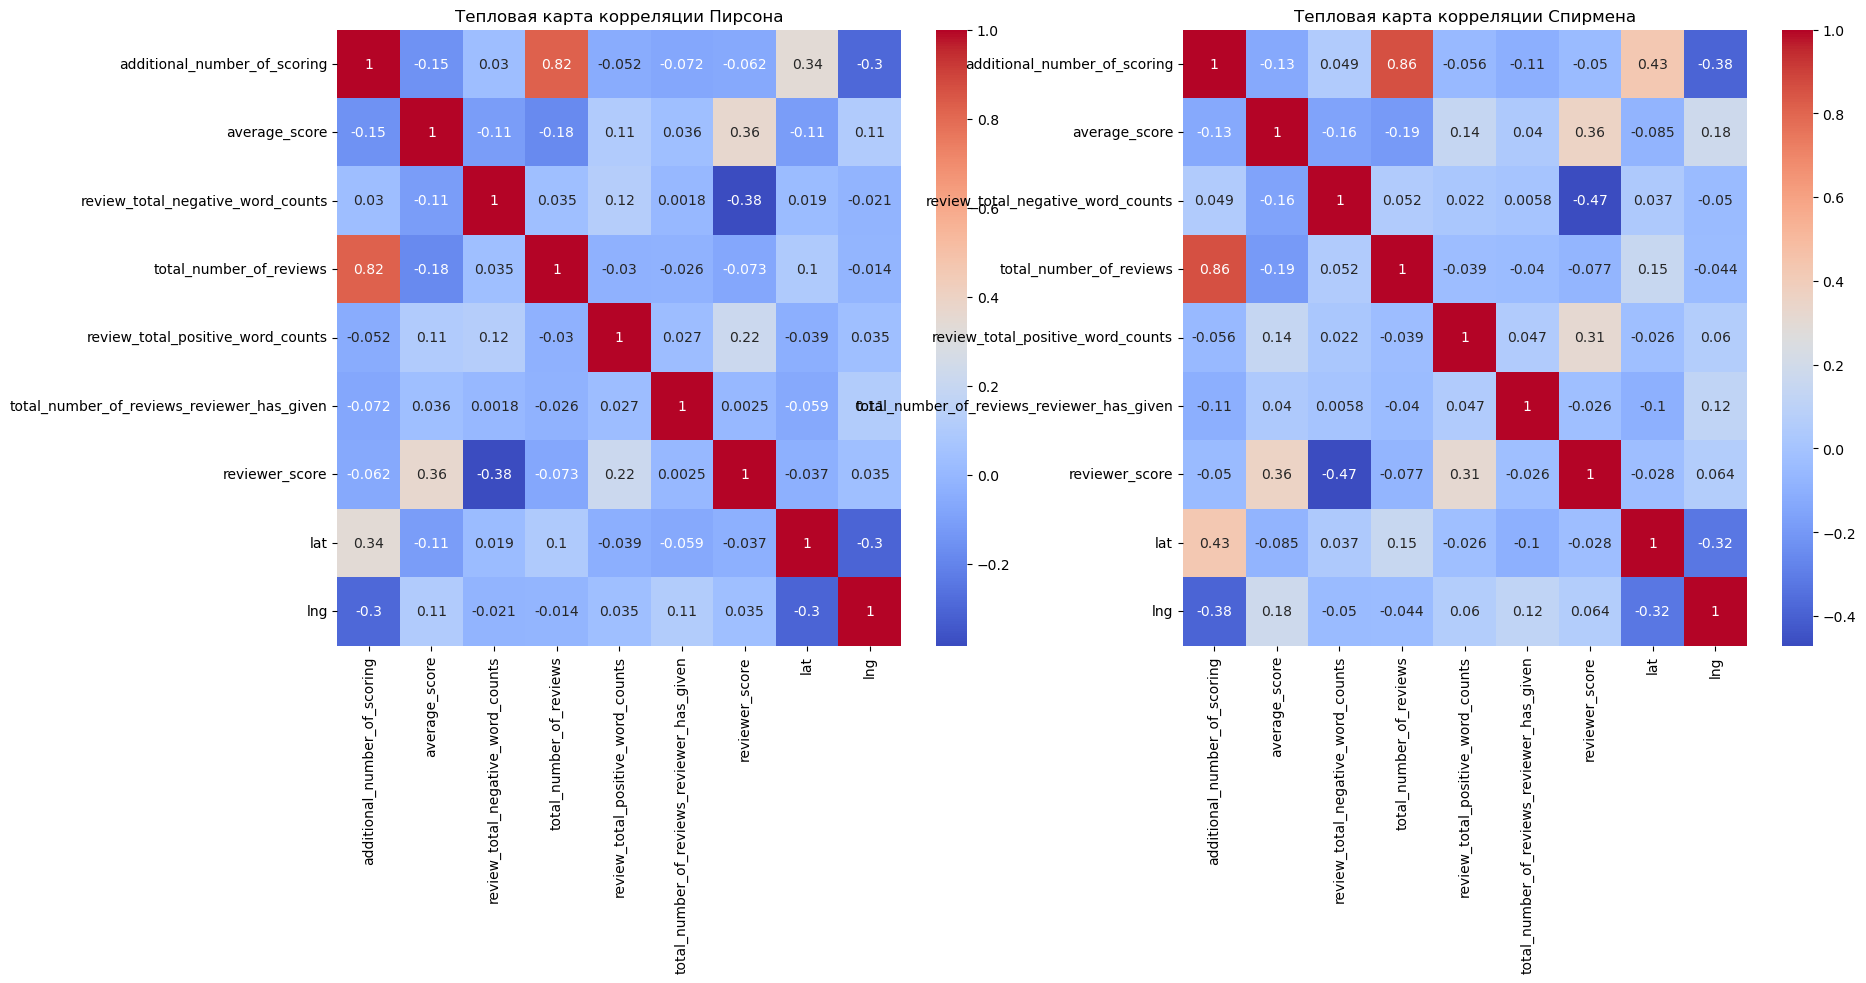

In [17]:
# Установка размера общей фигуры
plt.figure(figsize=(20, 8))

# Добавление первой подграфики для корреляции Пирсона
plt.subplot(1, 2, 1)  # 1 строка, 2 колонки, первая подграфика
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции Пирсона')

# Добавление второй подграфики для корреляции Спирмена
plt.subplot(1, 2, 2)  # 1 строка, 2 колонки, вторая подграфика
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm')
plt.title('Тепловая карта корреляции Спирмена')

# Отображение фигуры с двумя подграфиками
plt.show()

Матрица корреляции по Спирмену показала лучшие значения корреляций, но в целом картина коррелиции признаков между собой практически одинаковая.

С нашей целевой переменной 'reviewer_score' хорошо коррелируют признаки:
- average_score;
- review_total_negative_word_counts;
- review_total_positive_word_counts

Также мы видим высококоррелирующие между собой признаки 'total_number_of_reviews' и 'additional_number_of_scoring'. Попробуем их удалить в дальнейшем при обучении нашей модели и посмотреть на результат.

### Вывод: 
Благодаря матрицам корреляций можно сделать вывод, что у нас прослеживается нелинейная взаимосвязь в данных. Большинство признаков имеют низкие абсолютные значения коэффициентов корреляции с целевой переменной. Это пригодиться нам для дальнейшего исследования.

Но а с переменными 'lat' и 'lng' лучше всего коррелируют три признака:
- additional_number_of_scoring;
- total_number_of_reviews;
- average_score

Для начала посмотрим на результат модели, обучив ее без географических данных.

In [18]:
# Удаляем строки с пропущенными значениями 'lat' и 'lng'
hotels_clean = hotels.dropna(subset=['lat', 'lng'])

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_clean.drop(['reviewer_score'], axis = 1)  
y = hotels_clean['reviewer_score']

# Исключаем нечисловые столбцы
X_numeric = X.select_dtypes(include=[np.number])

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 20% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.20, random_state=42)

# Создаём нашу модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


MAPE: 0.1408967925456141


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.5s finished


Теперь нормализуем данные перед обучением.

In [19]:
# Инициализация MinMaxScaler
scaler = MinMaxScaler()
# Масштабирование обучающих данных
X_train_scaled = scaler.fit_transform(X_train)
# Масштабирование тестовых данных
X_test_scaled = scaler.transform(X_test)

# Создаём нашу модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train_scaled, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test_scaled)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s


MAPE: 0.1409015716810212


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


Нормализация данных оказала негативное влияние на производительность модели. Попробуем тогда стандартизировать данные перед обучением.

In [20]:
# Инициализация StandardScaler
scaler = StandardScaler()
# Масштабирование обучающих данных
X_train_scaled = scaler.fit_transform(X_train)
# Масштабирование тестовых данных
X_test_scaled = scaler.transform(X_test)

# Создаём нашу модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train_scaled, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test_scaled)  

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s


MAPE: 0.1408576274203664


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.9s finished


Как видим, стандартизация данных улучшила результат модели, хоть и не намного от первого исходного MAPE=0.1408967925456141

#### Заполнение недостающих значений для признаков 'lat' и 'lng'

Также нормализация признаков перед использованием метода K-Nearest Neighbors (KNN) является важным шагом. KNN опирается на расстояния между точками данных, и если признаки имеют разные масштабы, это может исказить вычисление расстояний и, как следствие, результаты модели. Нормализация данных помогает обеспечить, что каждый признак вносит равный вклад в расчет расстояния.
Наши данные содержат выбросы поэтому использование MinMaxScaler для нормализации данных перед применением KNN будут предпочтительнее, так как он менее чувствителен к выбросам.

In [21]:
# Создадим экземпляр MinMaxScaler
scaler = MinMaxScaler()

In [22]:
# Отбираем только наиболее важные признаки для KNN
important_features = ['additional_number_of_scoring', 'total_number_of_reviews', 'average_score']
X_knn = hotels_df[important_features + ['lat', 'lng']]

# Нормализуем признаки
X_scaled = scaler.fit_transform(X_knn)

# Создаем экземпляр KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Тут магия с заполнением пропусков
X_knn_imputed = knn_imputer.fit_transform(X_scaled)

# Преобразуем обратно к исходному масштабу
X_imputed_original = scaler.inverse_transform(X_knn_imputed)

# Добавление заполненных значений обратно в исходный датафрейм
hotels_df.loc[hotels_df['lat'].isnull(), 'lat'] = X_imputed_original[hotels_df['lat'].isnull(), -2]
hotels_df.loc[hotels_df['lng'].isnull(), 'lng'] = X_imputed_original[hotels_df['lng'].isnull(), -1]


In [23]:
# Посмотрим на пропуски в каждом столбце нашего датафрейма hotels_df
missing_values = hotels_df.isnull().sum()
missing_values

additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
review_total_negative_word_counts             0
total_number_of_reviews                       0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
lat                                           0
lng                                           0
dtype: int64

In [24]:
# Сравним исходный и обновленный датафреймы для 'lat'
filled_lat = hotels['lat'].isnull() & hotels_df['lat'].notnull()
print("Заполненные значения в 'lat':")
print(hotels_df.loc[filled_lat, 'lat'])

# Сравним исходный и обновленный датафреймы для 'lng'
filled_lng = hotels['lng'].isnull() & hotels_df['lng'].notnull()
print("\nЗаполненные значения в 'lng':")
print(hotels_df.loc[filled_lng, 'lng'])

Заполненные значения в 'lat':
122       41.400665
566       52.359478
724       45.461177
754       41.328376
1137      45.468425
            ...    
386092    48.185431
386465    48.185431
386504    45.468425
386702    48.185431
386764    41.328376
Name: lat, Length: 2448, dtype: float64

Заполненные значения в 'lng':
122        2.178709
566        4.895853
724        9.191047
754        2.112964
1137       9.183416
            ...    
386092    16.404884
386465    16.404884
386504     9.183416
386702    16.404884
386764     2.112964
Name: lng, Length: 2448, dtype: float64


Видим, что пустые данные заполнились и теперь мы не имеем пропусков в данных.

## Часть 3. Обучение модели на подготовленных данных, нахождение гиперпараметров

Меньший **MAPE** означает лучшую точность: Низкий процент ошибки указывает на то, что прогнозы модели в среднем ближе к фактическим значениям.

С учетом того, что ранее нормализация оказала негативное влияние на обучение модели без признаков 'lat' и 'lng' против стандартизации. Поэтому будем применять стандартизацию данных перед обучением.

Стандартизируем наши признаки, обучим модель на полных данных и посмотрим на результат.

In [25]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_df.drop(['reviewer_score'], axis = 1)  
y = hotels_df['reviewer_score'] 

# Исключаем нечисловые столбцы
X_numeric = X.select_dtypes(include=[np.number])

# Разделяем снова данные на тренировочные и тестовые  
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Инициализация StandardScaler
scaler = StandardScaler()
# Масштабирование обучающих данных
X_train_scaled = scaler.fit_transform(X_train)
# Масштабирование тестовых данных
X_test_scaled = scaler.transform(X_test)

# Создаём нашу модель  
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
      
# Обучаем модель на тренировочном наборе данных  
regr.fit(X_train_scaled, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test_scaled)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s


MAPE: 0.14136033551588034


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


#### Попробуем уменьшить MAPE и тем самым улучшить нашу модель

In [26]:
# Получим важность признаков
feature_importances = regr.feature_importances_

# Убедимся, что количество признаков в X_train соответствует количеству в feature_importances
if len(X_train.columns) == len(feature_importances):
    # Преобразование в DataFrame для лучшей визуализации
    features_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': feature_importances
    })

    # Отрортируем признаки по убыванию важности
    features_df.sort_values(by='Importance', ascending=False, inplace=True)

    # Посмотрим на результаты
    print(features_df)
else:
    print("Количество признаков и важностей не совпадает")

                                      Feature  Importance
2           review_total_negative_word_counts    0.330430
4           review_total_positive_word_counts    0.198227
5  total_number_of_reviews_reviewer_has_given    0.105667
1                               average_score    0.098005
6                                         lat    0.070802
7                                         lng    0.070707
3                     total_number_of_reviews    0.064514
0                additional_number_of_scoring    0.061648


#### Попробуем удалить малозначимые признаки

In [27]:
# Исключение выбранных признаков
X_train_reduced = X_train.drop(['additional_number_of_scoring'], axis=1)
X_test_reduced = X_test.drop(['additional_number_of_scoring'], axis=1)

# Подготовка данных для обучения и тестирования
# X_train_reduced = X_train[['average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts']]
# X_test_reduced = X_test[['average_score', 'review_total_negative_word_counts', 'review_total_positive_word_counts']]

# Масштабирование данных
scaler = StandardScaler()
X_train_reduced_scaled = scaler.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler.transform(X_test_reduced)

# Переобучение модели
regr = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=42)
# Обучаем модель на тренировочном наборе данных  
regr.fit(X_train_reduced_scaled, y_train)

# Оценка производительности
y_pred = regr.predict(X_test_reduced_scaled)

mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s


MAPE: 0.14115485046350867


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.7s finished


- Удаление самых незначимых признаков 'total_number_of_reviews', 'additional_number_of_scoring' ухудшило результат MAPE = 0.14138769727155268
- Также я пробовал оставить только значимые признаки которые лучшим образом коррелируют с целевой переменной = 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'average_score' результат стал хуже MAPE = 0.14231104921725943. 
- Но мы помним что два признака 'additional_number_of_scoring' и 'total_number_of_reviews' высококоррелируют между собой. Я принял решение удалить менее значимый на мой взгляд 'additional_number_of_scoring' и результат модели стал лучше MAPE = 0.14115485046350867.

#### Нахождение лучших Гиперпараметров

In [43]:
# Параметры для Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Создаем экземпляр модели
rf = RandomForestRegressor()

# Создаем экземпляр GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Выполнение Grid Search на масштабированных данных
grid_search.fit(X_train_scaled, y_train)

# Вывод лучших параметров
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\admin\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Лучшие параметры: {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


#### Обучим модель с лучшими гиперпараметрами

Используем max_features=1.0, следуя рекомендациям системы. Значение auto означает использование всех признаков (это эквивалентно None), что в нашем случае дает тот же результат, что и явное указание max_features=1.0 (использование 100% признаков).

In [28]:
# Исключение выбранных признаков
X_train = X_train.drop(['additional_number_of_scoring'], axis=1)
X_test = X_test.drop(['additional_number_of_scoring'], axis=1)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение модели с лучшими параметрами на масштабированных данных
best_regr = RandomForestRegressor(max_depth=10, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=300)
best_regr.fit(X_train_scaled, y_train)

# Предсказание
y_pred = best_regr.predict(X_test_scaled)

mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

MAPE: 0.13509203696187577


После нахождения лучших гиперпараметров модель показала пока лучший результат **MAPE = 0.13509203696187577**

## Часть 4. Преобразование признаков, повторное обучение модели и кросс-валидация

На этом этапе попробуем поработать с преобразование признаков

In [29]:
hotels_df = hotels_df.drop(['review_date', 'additional_number_of_scoring'], axis=1)

In [30]:
hotels_df.columns

Index(['average_score', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'lat',
       'lng'],
      dtype='object')

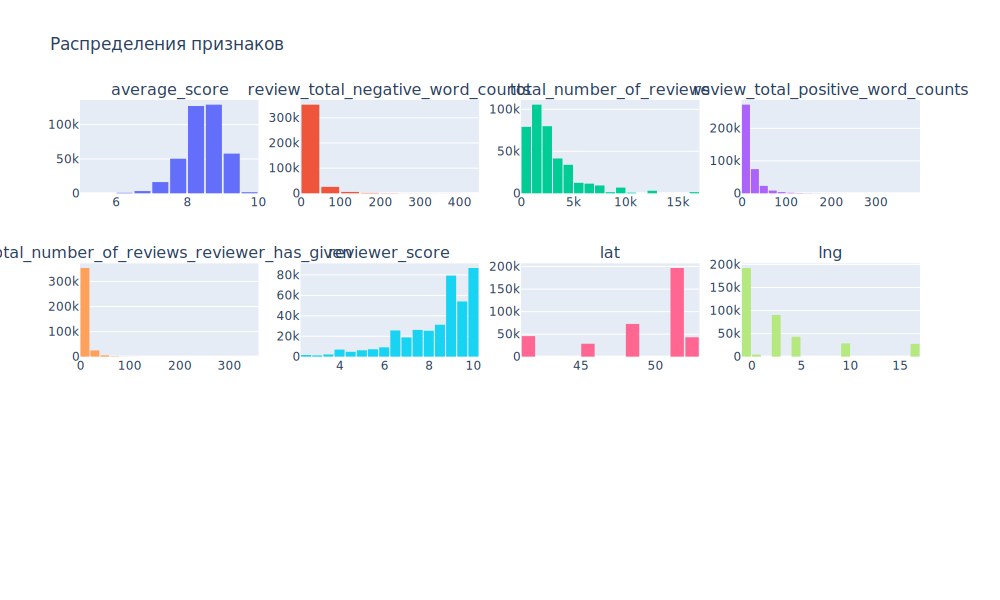

In [31]:
cols = ['average_score', 'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
        'reviewer_score', 'lat', 'lng']

fig = make_subplots(rows=3, cols=4, subplot_titles=cols)

# Создадим гистограммы для каждого признака
for i, feature in enumerate(cols, 1):
    fig.add_trace(go.Histogram(x=hotels_df[feature], nbinsx=20),
                  row=(i-1)//4 + 1, col=(i-1)%4 + 1)

fig.update_layout(title='Распределения признаков',
                  showlegend=False, width=1000, height=600,
                  #margin=dict(l=50, r=50, b=100, t=100, pad=4)
                 )

fig.layout.bargap = 0.1
fig.show('svg')

Применим оценку скошенности

In [32]:
# Оценка скошенности
skewed_features = hotels_df.apply(lambda x: x.skew()).sort_values(ascending=False)
highly_skewed = skewed_features[abs(skewed_features) > 0.5]
print(highly_skewed)

total_number_of_reviews_reviewer_has_given    5.072838
review_total_negative_word_counts             4.419273
review_total_positive_word_counts             4.149133
total_number_of_reviews                       2.086547
lng                                           1.875255
average_score                                -0.540733
reviewer_score                               -1.195633
lat                                          -1.385992
dtype: float64


Признаки 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lng' имеют высокое положительное значение скошенности, что указывает на сильное искажение вправо. Логарифмическое преобразование может быть особенно эффективным для уменьшения этой скошенности.

Добавим преобразованные признаки в датафрейм и удалим эти же признаки до преобразования

In [33]:
features_to_transform = ['total_number_of_reviews_reviewer_has_given', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews', 'lng']

for feature in features_to_transform:
    # Применяем логарифмическое преобразование с добавлением 1, чтобы избежать log(0)
    hotels_df[feature + '_log'] = np.log1p(hotels_df[feature])


In [34]:
hotels_df.drop(columns=['total_number_of_reviews_reviewer_has_given', 'review_total_negative_word_counts', 'review_total_positive_word_counts', 'total_number_of_reviews', 'lng'] , axis=1, inplace=True)

Посмотрим теперь как разпределяются признаки

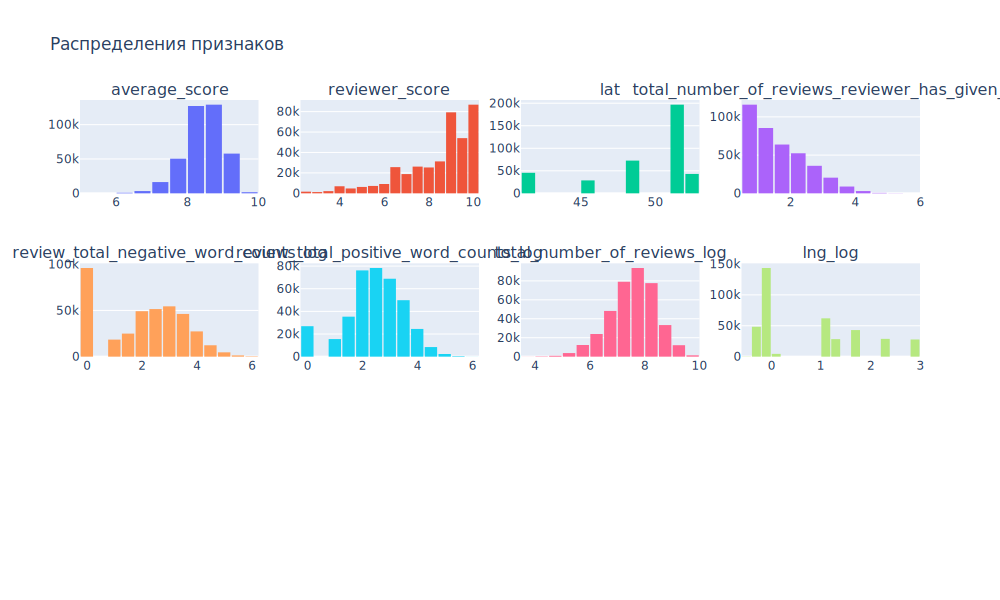

In [35]:
cols = ['average_score', 'reviewer_score', 'lat',
       'total_number_of_reviews_reviewer_has_given_log',
       'review_total_negative_word_counts_log',
       'review_total_positive_word_counts_log', 'total_number_of_reviews_log',
       'lng_log']

fig = make_subplots(rows=3, cols=4, subplot_titles=cols)

# Создадим гистограммы для каждого признака
for i, feature in enumerate(cols, 1):
    fig.add_trace(go.Histogram(x=hotels_df[feature], nbinsx=20),
                  row=(i-1)//4 + 1, col=(i-1)%4 + 1)

fig.update_layout(title='Распределения признаков',
                  showlegend=False, width=1000, height=600,
                  #margin=dict(l=50, r=50, b=100, t=100, pad=4)
                 )

fig.layout.bargap = 0.1
fig.show('svg')

Обучим нашу модель RandomForestRegressor после преобразования признаков

In [37]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_df.drop(['reviewer_score'], axis = 1)  
y = hotels_df['reviewer_score'] 

# Разделяем снова данные на тренировочные и тестовые  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Инициализация StandardScaler
scaler = StandardScaler()
# Масштабирование обучающих данных
X_train_scaled = scaler.fit_transform(X_train)
# Масштабирование тестовых данных
X_test_scaled = scaler.transform(X_test)

# Обучение модели с лучшими параметрами на масштабированных данных
best_regr = RandomForestRegressor(max_depth=10, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=300)
best_regr.fit(X_train_scaled, y_train)

# Предсказание
y_pred = best_regr.predict(X_test_scaled)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

MAPE: 0.1350975247864461


Пока что лучший результат модели **MAPE = 0.1350975247864461**

### Кросс-валидация

In [100]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Создание объекта RandomForestRegressor с наилучшими параметрами
rf = RandomForestRegressor(max_depth=10, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=300)

# Определение MAPE в качестве метрики
def mape_score(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mape_score, greater_is_better=False)

# Выполнение кросс-валидации
cv_scores = cross_val_score(rf, X, y, cv=5, scoring=mape_scorer)

# Вывод результатов
print(f"MAPE scores for each fold are: {cv_scores}")
print(f"Average MAPE score: {-np.mean(cv_scores)}")


MAPE scores for each fold are: [-13.36496771 -13.51941177 -13.51183157 -13.500779   -13.48511581]
Average MAPE score: 13.476421173006802


Результаты кросс-валидации показывают, что средняя ошибка MAPE нашей модели составляет примерно 13.48%. Это означает, что в среднем модель ошибается на 13.48% относительно фактических значений. Результаты относительно стабильны между различными фолдами, что указывает на то, что модель имеет постоянную производительность на различных подмножествах данных.

Результаты модели на независимом тестовом наборе данных MAPE = 13.50975247864461 очень близки к результатам кросс-валидации  MAPE = 13.476421173006802, что является хорошим признаком. Модель не переобучается.
Модель показывает согласованные результаты как на различных подмножествах обучающего набора данных, так и на независимом тестовом наборе, что является признаком её надёжности.

## Часть 5. Анализ ошибок

Для анализа ошибок, которые наша модель RandomForestRegressor совершает в предсказаниях, можно сначала определить случаи, где разница между фактическими значениями и предсказаниями наиболее значительна. Это поможет выявить шаблоны или особенности в данных, на которые модель реагирует неадекватно.

1) Для начала вычислим ошибки предсказаний (разницу между фактическими значениями и предсказанными).

In [39]:
errors = y_test - y_pred

2) А теперь отсортируем эти ошибки по величине, чтобы увидеть, в каких случаях модель ошиблась больше всего

In [40]:
# Создание DataFrame для анализа ошибок
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': errors})

# Сортировка по абсолютной ошибке в убывающем порядке
error_df['Absolute_Error'] = error_df['Error'].abs()
error_df.sort_values(by='Absolute_Error', ascending=False, inplace=True)

In [80]:
error_df.head(10)

,Actual,Predicted,Error,Absolute_Error
215645,2.5,9.725514,-7.225514,7.225514
191234,2.5,9.675883,-7.175883,7.175883
29673,2.5,9.580266,-7.080266,7.080266
105350,2.5,9.515444,-7.015444,7.015444
87625,2.5,9.502238,-7.002238,7.002238
65024,2.5,9.474168,-6.974168,6.974168
42429,2.5,9.424806,-6.924806,6.924806
176398,2.5,9.406516,-6.906516,6.906516
310734,2.5,9.361566,-6.861566,6.861566
203319,2.5,9.347298,-6.847298,6.847298


In [75]:
hotels_df.columns

Index(['average_score', 'reviewer_score', 'lat',
       'total_number_of_reviews_reviewer_has_given_log',
       'review_total_negative_word_counts_log',
       'review_total_positive_word_counts_log', 'total_number_of_reviews_log',
       'lng_log'],
      dtype='object')

3) Визуализируем ошибки модели на гистограмме и ящике с усами

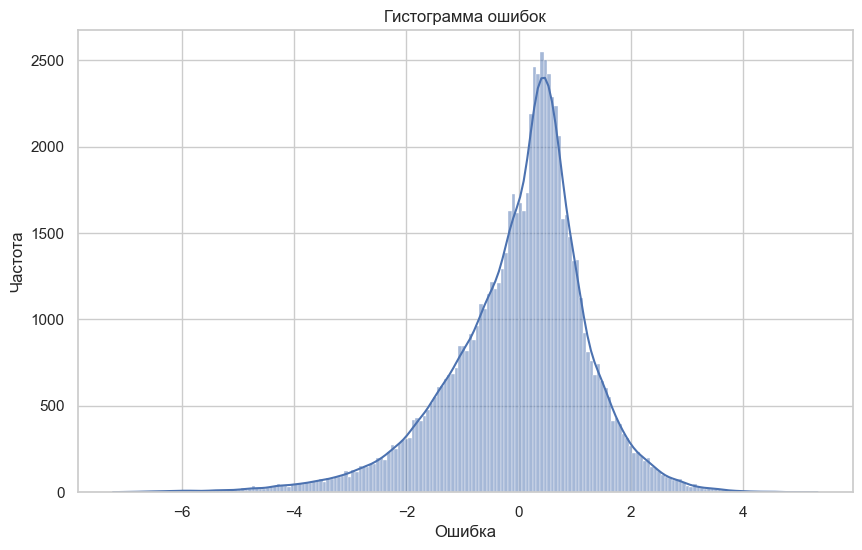

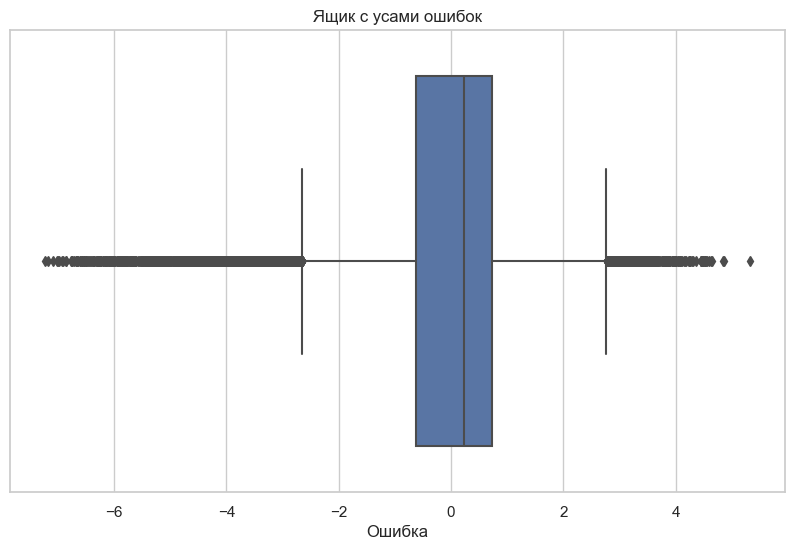

In [99]:
# error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Error': errors, 'Absolute_Error': errors.abs()})

# Гистограмма ошибок
plt.figure(figsize=(10, 6))
sns.histplot(error_df['Error'], kde=True)
plt.title('Гистограмма ошибок')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.show()

# Ящик с усами ошибок
plt.figure(figsize=(10, 6))
sns.boxplot(x=error_df['Error'])
plt.title('Ящик с усами ошибок')
plt.xlabel('Ошибка')
plt.show()

На гистограмме ошибки сгруппированы вокруг нуля, что указывает на то, что модель во многих случаях достаточно точна. Однако также заметно, что есть длинные хвосты, особенно в отрицательном направлении, что указывает на наличие случаев с большими ошибками, когда модель значительно переоценивает фактические значения.

Из ящика с усами видно, что основная часть данных (межквартильный размах) сосредоточена вокруг нуля, что также указывает на то, что большинство предсказаний модели достаточно точные. Однако длинные усы и отдельные точки, выходящие за пределы усов (то есть выбросы), показывают, что существуют случаи с большими отрицательными и положительными ошибками.

Модель имеет склонность к переоценке, особенно в случаях с большими отрицательными ошибками, что видно по левому усу, который длиннее правого. Несмотря на наличие выбросов, распределение ошибок кажется симметричным вокруг нуля, что хорошо для баланса модели. Медиана ошибок, вероятно, близка к нулю, и межквартильный размах не очень широк, что указывает на то, что модель в большинстве случаев дает точные предсказания.

4) А теперь попробуем выявить данные которые приводят к большим ошибкам. Для этого для начала установим порог на 95м процентиле распределения абсолютных ошибок, тем самым мы рассмотрим 5% случаев с большими ошибками. Затем идентифицируем такие случаи с большими ошибками и сравним их с случаями, где ошибки были минимальны (общее распределение). Ну а далее визуализируем эти данные для наглядного понимания.

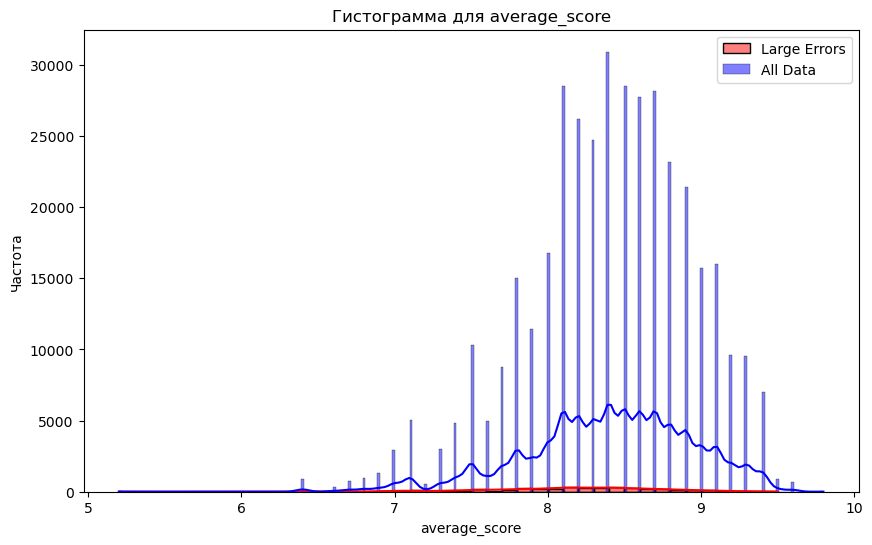

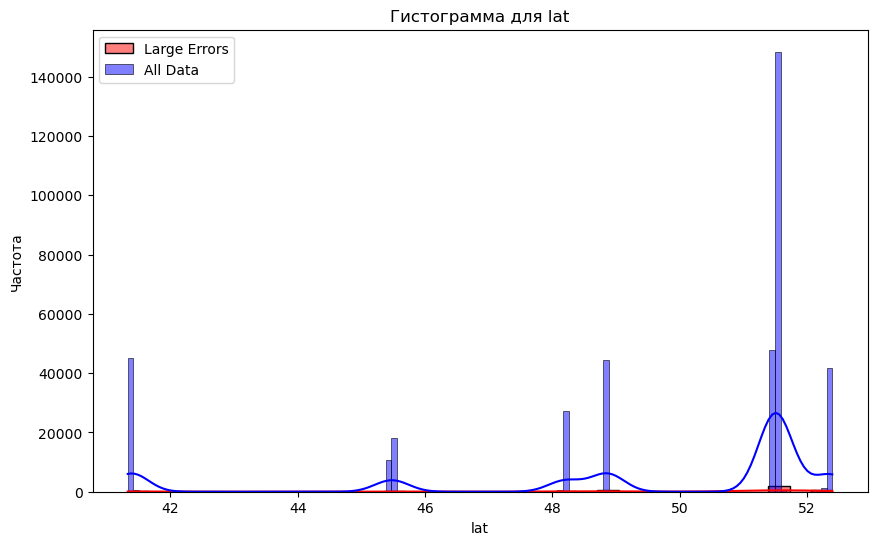

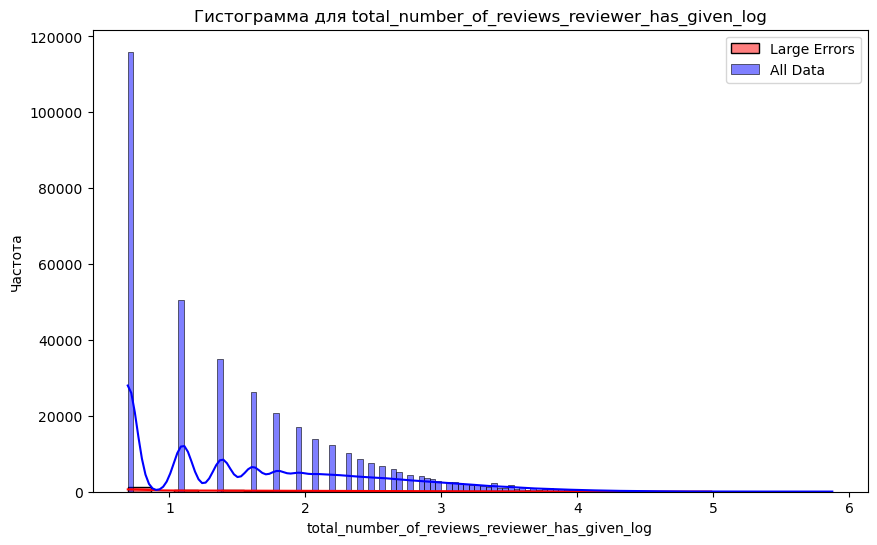

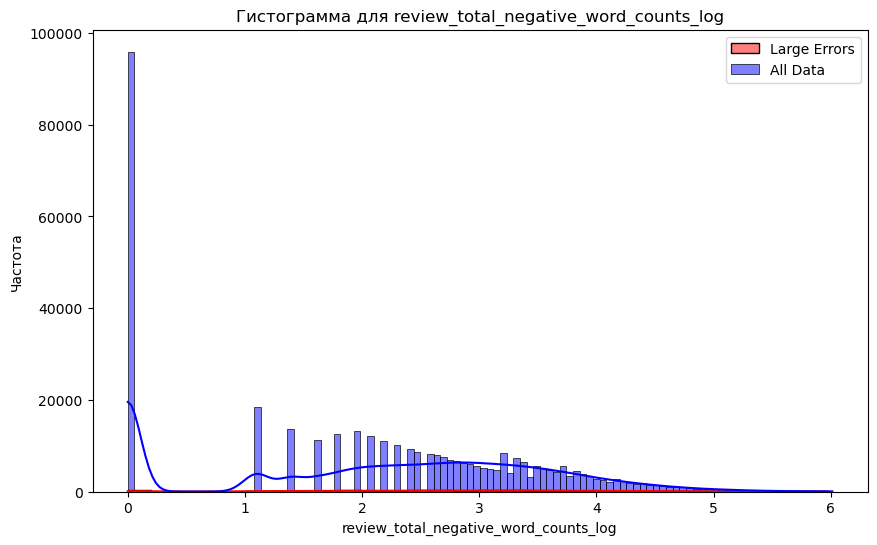

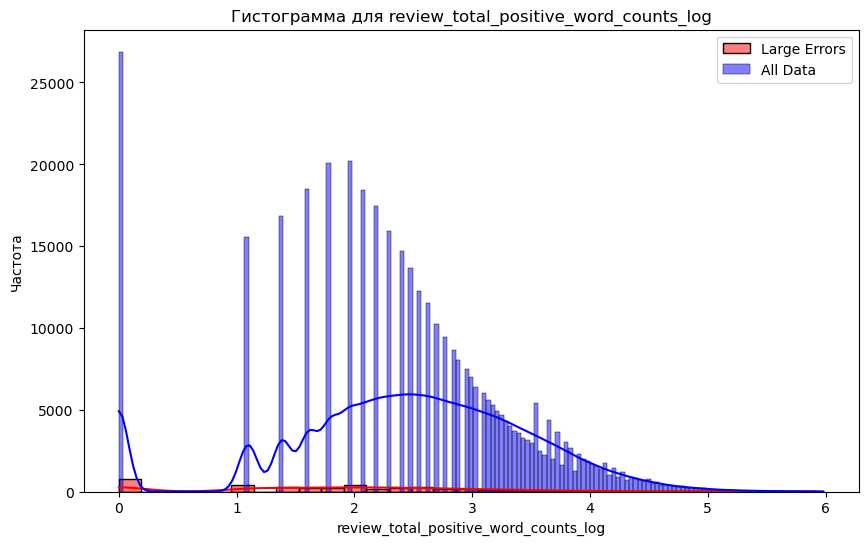

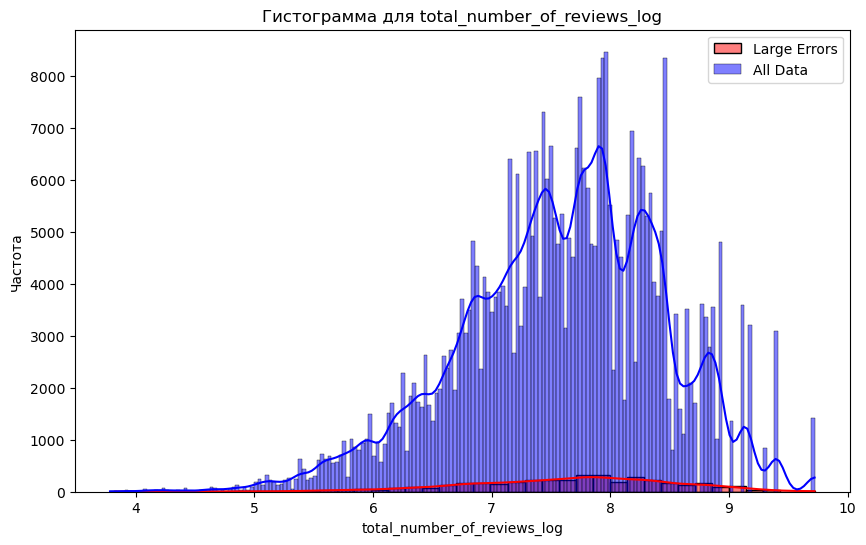

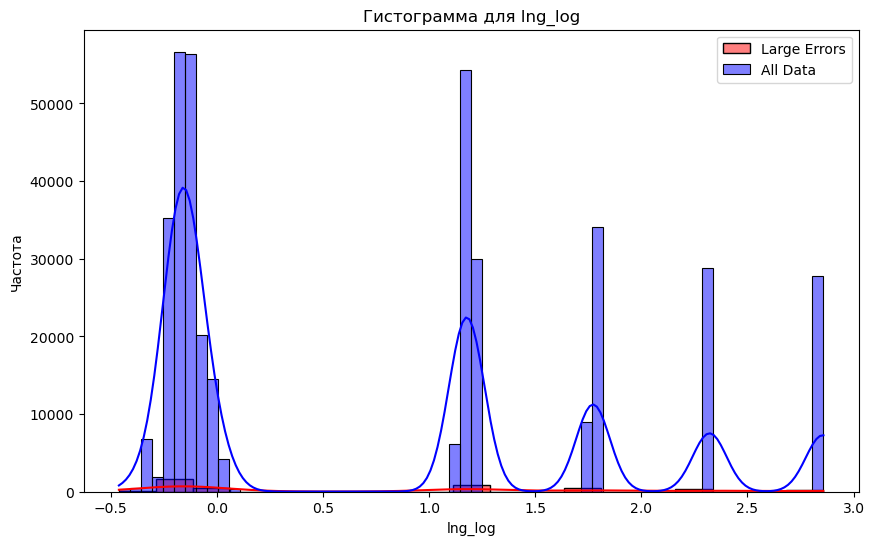

In [89]:
# Определение порога для больших ошибок
threshold = error_df['Absolute_Error'].quantile(0.95)

# Идентификация случаев с большими ошибками
large_errors = error_df[error_df['Absolute_Error'] > threshold]

# Выборка случаев с большими ошибками из исходного датафрейма
large_error_cases = hotels_df.loc[large_errors.index]


# Визуализация распределения признаков для случаев с большими ошибками
# (выберем признак 'feature_to_visualize' для визуализации)
# feature_to_visualize = 'average_score'
features_to_visualize = ['average_score', 
    'lat', 
    'total_number_of_reviews_reviewer_has_given_log', 
    'review_total_negative_word_counts_log', 
    'review_total_positive_word_counts_log', 
    'total_number_of_reviews_log', 
    'lng_log']


# Гистограмма для случаев с большими ошибками
#sns.histplot(large_error_cases[feature_to_visualize], color='red', label='Large Errors')
# Гистограмма для всех данных
#sns.histplot(hotels_df[feature_to_visualize], color='blue', label='All Data', alpha=0.5)
#plt.legend()
#plt.show()

# Гистограммы для случаев с большими ошибками и для всех данных
for feature_to_visualize in features_to_visualize:
    plt.figure(figsize=(10, 6))
    sns.histplot(large_error_cases[feature_to_visualize], color='red', label='Large Errors', kde=True)
    sns.histplot(hotels_df[feature_to_visualize], color='blue', label='All Data', alpha=0.5, kde=True)
    plt.title(f'Гистограмма для {feature_to_visualize}')
    plt.xlabel(feature_to_visualize)
    plt.ylabel('Частота')
    plt.legend()
    plt.show()



На основе предоставленных гистограмм можно утверждать, что ошибки модели распределены по всему диапазону значений каждого из рассмотренных признаков. Это означает, что не существует явного однозначного признака или узкого диапазона значений признаков, который был бы ответственен за все большие ошибки.

## Часть 6. Удаление выбросов и повторное обучение модели

In [106]:
# Определение IQR для каждого признака
Q1 = hotels_df.quantile(0.25)
Q3 = hotels_df.quantile(0.75)
IQR = Q3 - Q1

# Фильтрация выбросов
filtered_df = hotels_df[~((hotels_df < (Q1 - 1.5 * IQR)) |(hotels_df > (Q3 + 1.5 * IQR))).any(axis=1)]

In [108]:
# После фильтрации, разделим данные на признаки и целевую переменную и проведем снова обучение модели
X_filtered = filtered_df.drop('reviewer_score', axis=1)
y_filtered = filtered_df['reviewer_score']

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

# Инициализируем StandardScaler
scaler = StandardScaler()
# Масштабируем обучающие данные
X_train_scaled = scaler.fit_transform(X_train)
# Масштабируем тестовые данные
X_test_scaled = scaler.transform(X_test)

# Обучение модели
rf = RandomForestRegressor(max_depth=10, max_features=1.0, min_samples_leaf=4, min_samples_split=10, n_estimators=300)
rf.fit(X_train_scaled, y_train)

# Предсказание и оценка модели
y_pred = rf.predict(X_test_scaled)
test_mape = metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"Test MAPE: {test_mape}")

Test MAPE: 0.11071617526439954


Попытка избавиться от выбросов привела к успеху. Нам значительно удалось улучшить результат производительности модели, так как модели удалось обучиться на более репрезентативных данных.

## Общий вывод

В ходе данного проекта мы работали с отзывами на отели Европы, для построения модели, которая способна предсказать рейтинг отеля по данным сайта Booking.
Перед обучением модели мы познакомились с данными, очистили датасет от категориальных данных (object), произвели заполнение пропусков у признаков lat и lng через метод K-Nearest Neighbors, посмотрели как коррелируют между собой числовые признаки.
В данном проекте, исходя из учебного задания, мы работали с моделью RandomForestRegration. Нашли для нее наилучшие гиперпараметры, произвели преобразование признаков в логарифмической шкале, проделали кросс-валидацию и убедились, что модель не переобучается. Анализировали ошибки модели, где убедились, что ошибки не связаны с какими-то отдельными признаками.
Модель была обучена несколько раз, пока мы не достигли наилучшей точности по показателю **MAPE = 0.11071617526439954**.
Такого показателя мы достигли благодаря удалению выбросов в данных.